import numpy.random as random
from astropy import units as u
import matplotlib.patches as patches
def: find_nearest(array, value)
def: powerfunc_six(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4,amp5,shift5,amp6,shift6)
def: powerfunc_four(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4)
def: powerfunc(hpp,amp1,shift1,amp2,shift2,amp3,shift3)
def: powerfuncsingle(hpp,amp1,shift1)
data_dir :  ~/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data
data_path :  ~/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data/processed/luhman_16ab_sector36-37.txt
plot_dir :  ~/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/plots
def: find_nearest(array, value)


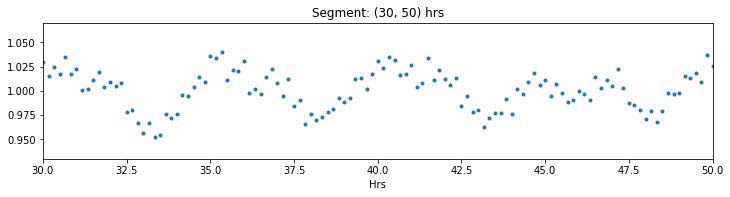

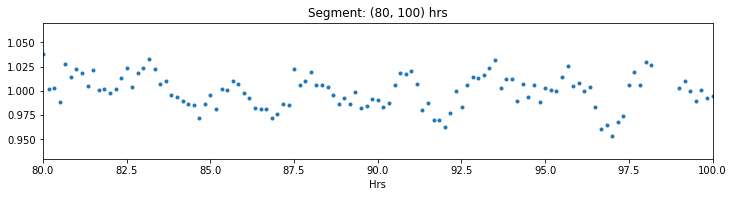

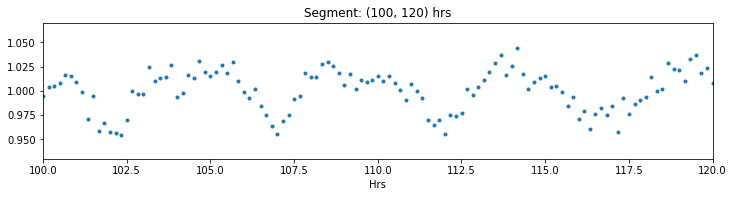

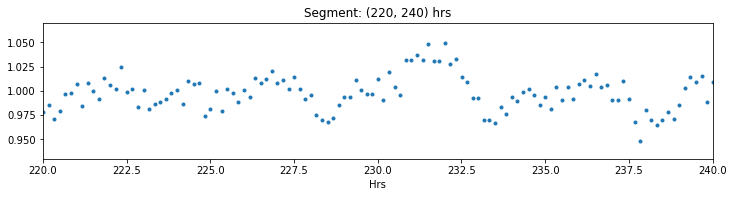

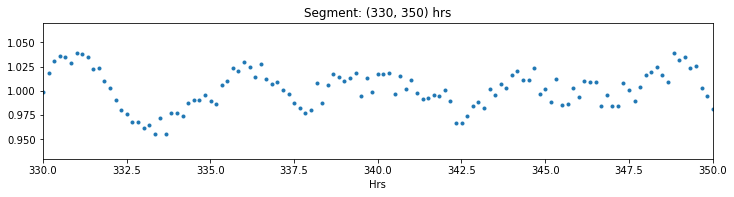

In [1]:
from AROMA import *
from AROMA.utils import *
from AROMA.config import *
import pandas as pd
from scipy.optimize import curve_fit

%matplotlib inline

pi = np.pi 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
print('def: find_nearest(array, value)')

import os
from os.path import join
array = os.path.abspath('').split('/')
homedir = '/'
for i in range(1,7):
   homedir = join(homedir, array[i])
homedir

data_path = '~/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data/processed/luhman_16ab_sector36-37_longPeriodsRemoved.txt'
data = pd.read_csv(data_path, header=0, delimiter='\t')
plotPath = join(homedir, 'plots')

# data = data.query('TIME < 2293') # first half of sector 36 
# data = data.query('TIME > 2293 & TIME < 2306') # second half of sector 36 
# data = data.query('TIME < 2306') # full of sector 36

# data = data.query('TIME > 2306 & TIME < 2320') # first half of sector  37 
# data = data.query('TIME > 2320') # second half of sector  37 
# data = data.query('TIME > 2306') # full of sector 37

data = data # full light curve
fit_dir = join(homedir,'notebooks', 'periodSineFit_metadata')

time, lc = data.TIME, data.lc_corrected
# segments = [(30,80), (80,130), (150,200), (220,270), (330, 380)]
segments = [(30,50), (80,100), (100,120), (220,240), (330, 350)]
for seg in segments:
    plt.figure(figsize=(12, 2.5)), plt.plot(time, lc, ls='', marker='o', ms=3.0), plt.xlim(seg), plt.xlabel('Hrs'), plt.title("Segment: "+str(seg)+" hrs"), plt.ylim((0.93, 1.07))

## Scipy Optimize Linear Regression Fit

Before doing our Markov Chain Monte Carlo (MCMC) Fit, we want to try a simple LR fit first to
1. define good bounds for the priors
2. obtain good guesses for the initial guess

All these will goes into the MCMC fit!

[0.0249871  0.00792028]
[ 0.02565402 -0.00881499]
[ 0.02502342 -0.02018924]
[1.25417288 2.74995058 1.25000261]
[5.00982392 2.28483572 5.02653774] hours


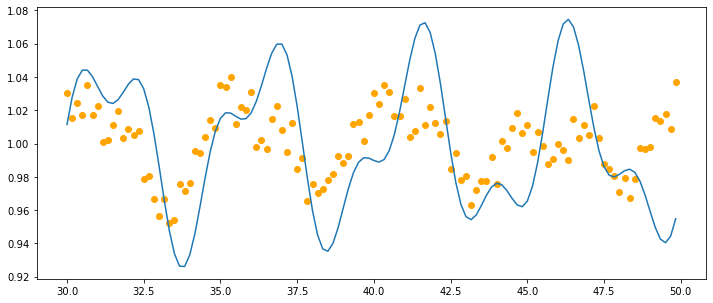

In [2]:
def altmodel(a1, f1, a2, f2, a3, f3, w1, w2, w3, t):
    model = 1+ a1*np.sin(w1*t + f1) + a2*np.sin(w2*t + f2) + a3*np.sin(w3*t + f3)
    return model

tlow, thigh = segments[0]
subset = data.query('TIME < %f & TIME >= %f'%(thigh, tlow))
time = np.array(subset.TIME)
lc = np.array(subset.lc_corrected)
lc_err = 0.05*np.array(subset.lc_corrected)

# guesses = [0.005, 0.5, 0.002, -1, 0.002, 3, 1.2, 1.5, 2.1]
lim = [(0, 0.05), (-10*pi, 10*pi), 
       (0, 0.05), (-10*pi, 10*pi), 
       (0, 0.05), (-10*pi, 10*pi), 
       (1, 1.5), (2.5, 3), (1., 1.5)]
df = ((time, lc, lc_err))

### GUESSES AND BOUNDS
# popt, pcov = curve_fit(altmodel, time, lc, p0=guesses, bounds=np.transpose(lim))
### BOUNDS ONLY
popt, pcov = curve_fit(altmodel, time, lc, bounds=np.transpose(lim))
### NONE
# popt, pcov = curve_fit(altmodel, time, lc)

a1, f1, a2, f2, a3, f3, w1, w2, w3 = popt
fit = altmodel(a1, f1, a2, f2, a3, f3, w1, w2, w3, t=time)

plt.figure(figsize=(12,5)), plt.plot(time, fit), plt.scatter(time, lc, c='orange')
print(popt[0:2])
print(popt[2:4])
print(popt[4:6])
print(popt[6:9])
print(2*pi/popt[6:9], 'hours')

# emcee Markov Chain Monte Carlo (MCMC)

### Run the LR fit first to obtain `lim` bounds!
Declare four functions:

1. **model()**: The model function should take as an argument a list representing our θ vector, and return the model evaluated at that θ.
2. **lnlike()**: This function takes as an argument theta as well as the x, y, and $y_\text{err}$ of your actual theta. It’s job is to return a number corresponding to how good a fit your model is to your data for a given set of parameters, weighted by the error in your data points
3. **lnprior()**: This function is to check - before running the probability function on any set of parameters - that all variables are within their priors (in fact, this is where we set our priors). Reasonable bounds on the amplitudes can be drawn from the data (e.g. amplitudes can't be greate than overall signal, periods within expected bounds, no negative amplitudes, etc).
4. **lnprob()**: This function combines the steps above by running the lnprior function, and if the function returned -np.inf, passing that through as a return, and if not (if all priors are good), returning the lnlike for that model (by convention we say it’s the lnprior output + lnlike output, since lnprior’s output should be zero if the priors are good). lnprob needs to take as arguments theta, x, y, and $y_\text{err}$ since these get passed through to lnlike. 

In [3]:
import emcee

def model(theta, t=time):
    a1, f1, a2, f2, a3, f3, w1, w2, w3 = theta
    model = 1 + a1*np.sin(w1*t + f1) + a2*np.sin(w2*t + f2) + a3*np.sin(w3*t + f3)
    return model

def lnlike(theta, x, y, yerr):
    LnLike = -0.5 * np.sum( ((y-model(theta,t=x))/yerr)**2 )
    return LnLike

def lnprior(theta, lim=lim):
    a1, f1, a2, f2, a3, f3, w1, w2, w3 = theta
    
    lim = [(1e-3, 1e-1), (-pi, pi), 
           (1e-3, 1e-1), (-pi, pi), 
           (1e-3, 1e-1), (-pi, pi), 
           (1, 1.5),     (1, 1.5) , (2.5, 3)]
    
    mn, mx = np.array(lim).T
    x = theta[:, None]
    withinbounds = ((x >= mn) & (x <= mx)).all(1)
    
    if np.all(withinbounds):
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if np.isinf(lp):
        return -np.inf
    else:
        return lp + lnlike(theta, x, y, yerr) #recall if lp not -inf, its 0, so this just returns likelihood

1. We also need to set a value for nwalkers, which determines how many walkers are initialized in our MCMC. Let’s use 500.
2. We need a variable called initial, which is an initial set of guesses (this will be the first theta, where the MCMC starts). **Foreman-Mackey & Hogg recommend that in many cases, running an optimizer first (e.g., from scipy) is the best way to select an initial starting value.**

In [4]:
# read initial from hyperopt metadata
folder = join(homedir,'notebooks', 'lightCurveFit_metadata')
handle_case = 'freeFreq'
handle_code = 'hyperOPT'
filename = '%s_sector3637_%i_%i-hr_%s_fitMeta.pkl'%(handle_code, tlow, thigh, handle_case)

import pickle

with open(join(folder, filename), 'rb') as file:
    tpe = pickle.load(file)    
    
initial = [tpe['a1'][0], tpe['f1'][0],
           tpe['a2'][0], tpe['f2'][0],
           tpe['a3'][0], tpe['f3'][0],
           tpe['w1'][0], tpe['w2'][0], tpe['w3'][0]] 
initial, tpe 

([0.010844633430333069,
  -2.481470844567734,
  0.016608125234350898,
  -0.688420545294217,
  0.011361379602910037,
  1.4877715870582238,
  1.1564214707052776,
  1.300318992187238,
  2.528211059303355],
 {'a0': [1.0000524775335733, [0, 2]],
  'a1': [0.010844633430333069, [0, 0.1]],
  'a2': [0.016608125234350898, [-3.141592653589793, 3.141592653589793]],
  'a3': [0.011361379602910037, [0, 0.1]],
  'f1': [-2.481470844567734, [-3.141592653589793, 3.141592653589793]],
  'f2': [-0.688420545294217, [0, 0.1]],
  'f3': [1.4877715870582238, [-3.141592653589793, 3.141592653589793]],
  'w1': [1.1564214707052776, [1, 1.5]],
  'w2': [1.300318992187238, [1, 1.5]],
  'w3': [2.528211059303355, [2.5, 3]],
  'hr': (30, 50),
  'known_freq': False,
  'code': 'hyperOPT'})

In [5]:
df = ((time, lc, lc_err))

#set nwalkers
nwalkers = 200
niter = 10000

# initial = popt
# initial = [2e-2+5e-3*np.random.rand(), 5*np.random.rand(), 
#            2e-2+5e-3*np.random.rand(), 5*np.random.rand(), 
#            2e-2+5e-3*np.random.rand(), 5*np.random.rand(),
#            1.2+0.5*np.random.rand(), 3+0.5*np.random.rand(), 1.1+0.5*np.random.rand()]
### HYPEROPT guesses
# initial = [1.08e-2, -2.48,
#             1.66e-2, -0.69,
#             1.14e-2, 1.49,
#             1.156, 1.300, 2.528] 

ndim = len(initial)

# p0=[]
# for i in range(nwalkers):
#     array = np.array([initial[0] + 1e-3*np.random.randn(1), initial[1] + 15*np.random.randn(1),
#                       initial[2] + 1e-3*np.random.randn(1), initial[3] + 15*np.random.randn(1),
#                       initial[4] + 1e-3*np.random.randn(1), initial[5] + 15*np.random.randn(1),
#                       initial[6] + 1e-1**np.random.randn(1), initial[7] + 1e-1*np.random.randn(1), initial[8] + 1e-1*np.random.randn(1)])
#     p0.append(array.T)
    
weights = np.array((1e-2, 1e-3, 1e-2, 1e-3, 1e-2, 1e-3, 1e-3, 1e-3, 1e-3))
# weights = 1e-3
p0 = [np.array(initial) + weights*np.random.randn(ndim) for i in range(nwalkers)]

#create initial priors by scipy.optimize

def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=df)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 200, progress=True)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,df)

Running burn-in...


  0%|                                                   | 0/200 [00:00<?, ?it/s]/Users/nguyendat/opt/anaconda3/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|████████████████████████████████████████| 200/200 [00:00<00:00, 249.45it/s]


Running production...


100%|████████████████████████████████████| 10000/10000 [00:40<00:00, 246.78it/s]


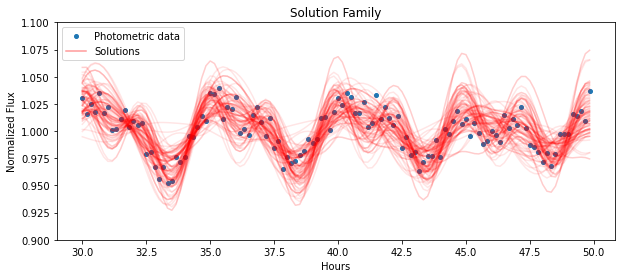

In [6]:
### Plotting solution family
save = False
def plotter(sampler,t=time,flux=lc):
    plt.figure(figsize=(10,4))
    plt.plot(t,flux,label='Photometric data', ls='', marker='o', ms=4)
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(t, model(theta, t), color="r", alpha=0.1)
    plt.plot(t[0], 1, color="r", alpha=0.4, label='Solutions')
    plt.title('Solution Family') 
    plt.xlabel('Hours')
    plt.ylabel(r'Normalized Flux')
    plt.legend(), plt.ylim((0.9, 1.1))
    
    ## Saving
    if save:
        handle_code = 'MCMC'
        plotOut = plotPath + '/familySolution_%s_sector3637_%i_%i-hr_fit'%(handle_code, tlow, thigh)
        plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
        plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

    plt.show()
plotter(sampler)

## Now we plot the best fit solution and the prior probability distribution 

Best theta fit
a1, f1:  [ 0.01555063 -2.48196895]
a2, f2:  [ 0.01794671 -0.6872739 ]
a3, f3:  [0.02106416 1.48676756]
w1, w2, w3:  [1.15563669 1.3003861  2.52833831]
periods 1, 2, 3 (hours):  [5.43699016 4.83178441 2.48510465]


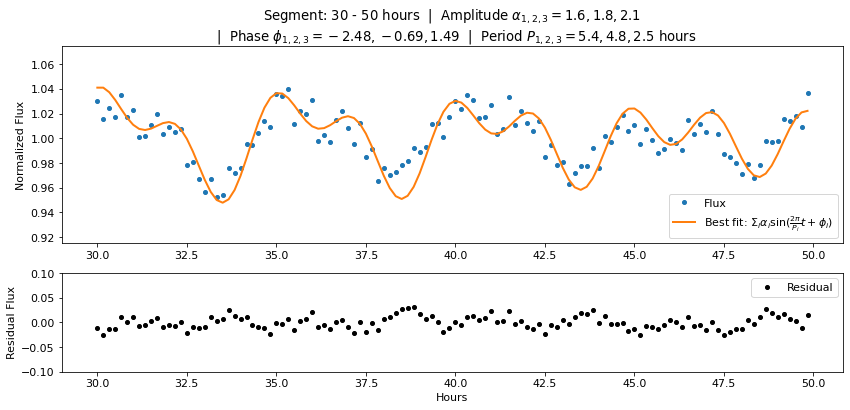

In [20]:
samples = sampler.flatchain
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

## BEST FIT SOLUTION
theta_max  = samples[np.argmax(sampler.flatlnprobability)]
print('Best theta fit')
print('a1, f1: ', theta_max[0:2])
print('a2, f2: ', theta_max[2:4])
print('a3, f3: ', theta_max[4:6])
print('w1, w2, w3: ', theta_max[6:9])
print('periods 1, 2, 3 (hours): ', 2*pi/theta_max[6:9])

best_fit_model = model(theta_max)
# plt.figure(figsize=(12,8))
f, (a0, a1) = plt.subplots(2, 1, figsize = (14,6), gridspec_kw={'height_ratios': [2, 1]})
a0.set_title('Segment: %i - %i hours'%(tlow, thigh)
           + r'  |  Amplitude $ \alpha_{1,2,3}=%.1f, %.1f, %.1f $' %(theta_max[0]*100, theta_max[2]*100, theta_max[4]*100)
           + '\n' + r'  |  Phase $ \phi_{1,2,3}=%.2f, %.2f, %.2f $' %(theta_max[1], theta_max[3], theta_max[5])
           + r'  |  Period $ P_{1,2,3}=%.1f, %.1f, %.1f $ hours'   %(2*pi/theta_max[6], 2*pi/theta_max[7], 2*pi/theta_max[8]) )
a0.plot(time,lc,label='Flux',ls='', marker='o', ms=4)
a0.plot(time,best_fit_model,label=r'Best fit: $\Sigma_i \alpha_i \sin(\frac{2\pi}{P_i}t + \phi_i)  $', lw=2)
a0.set_ylim((0.915, 1.075)), a0.legend()
a0.set_ylabel('Normalized Flux')
a1.plot(time,lc - best_fit_model,label='Residual', ls='', marker='o', ms=4, c='k'), plt.legend()
a1.set_ylim((-0.1,0.1))
a1.set_ylabel('Residual Flux')
a1.set_xlabel('Hours')

## Saving
save = True
if save:
    handle_code = 'MCMC'
    plotOut = plotPath + '/%s_sector3637_%i_%i-hr_fit'%(handle_code, tlow, thigh)
    f.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    f.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

plt.show()

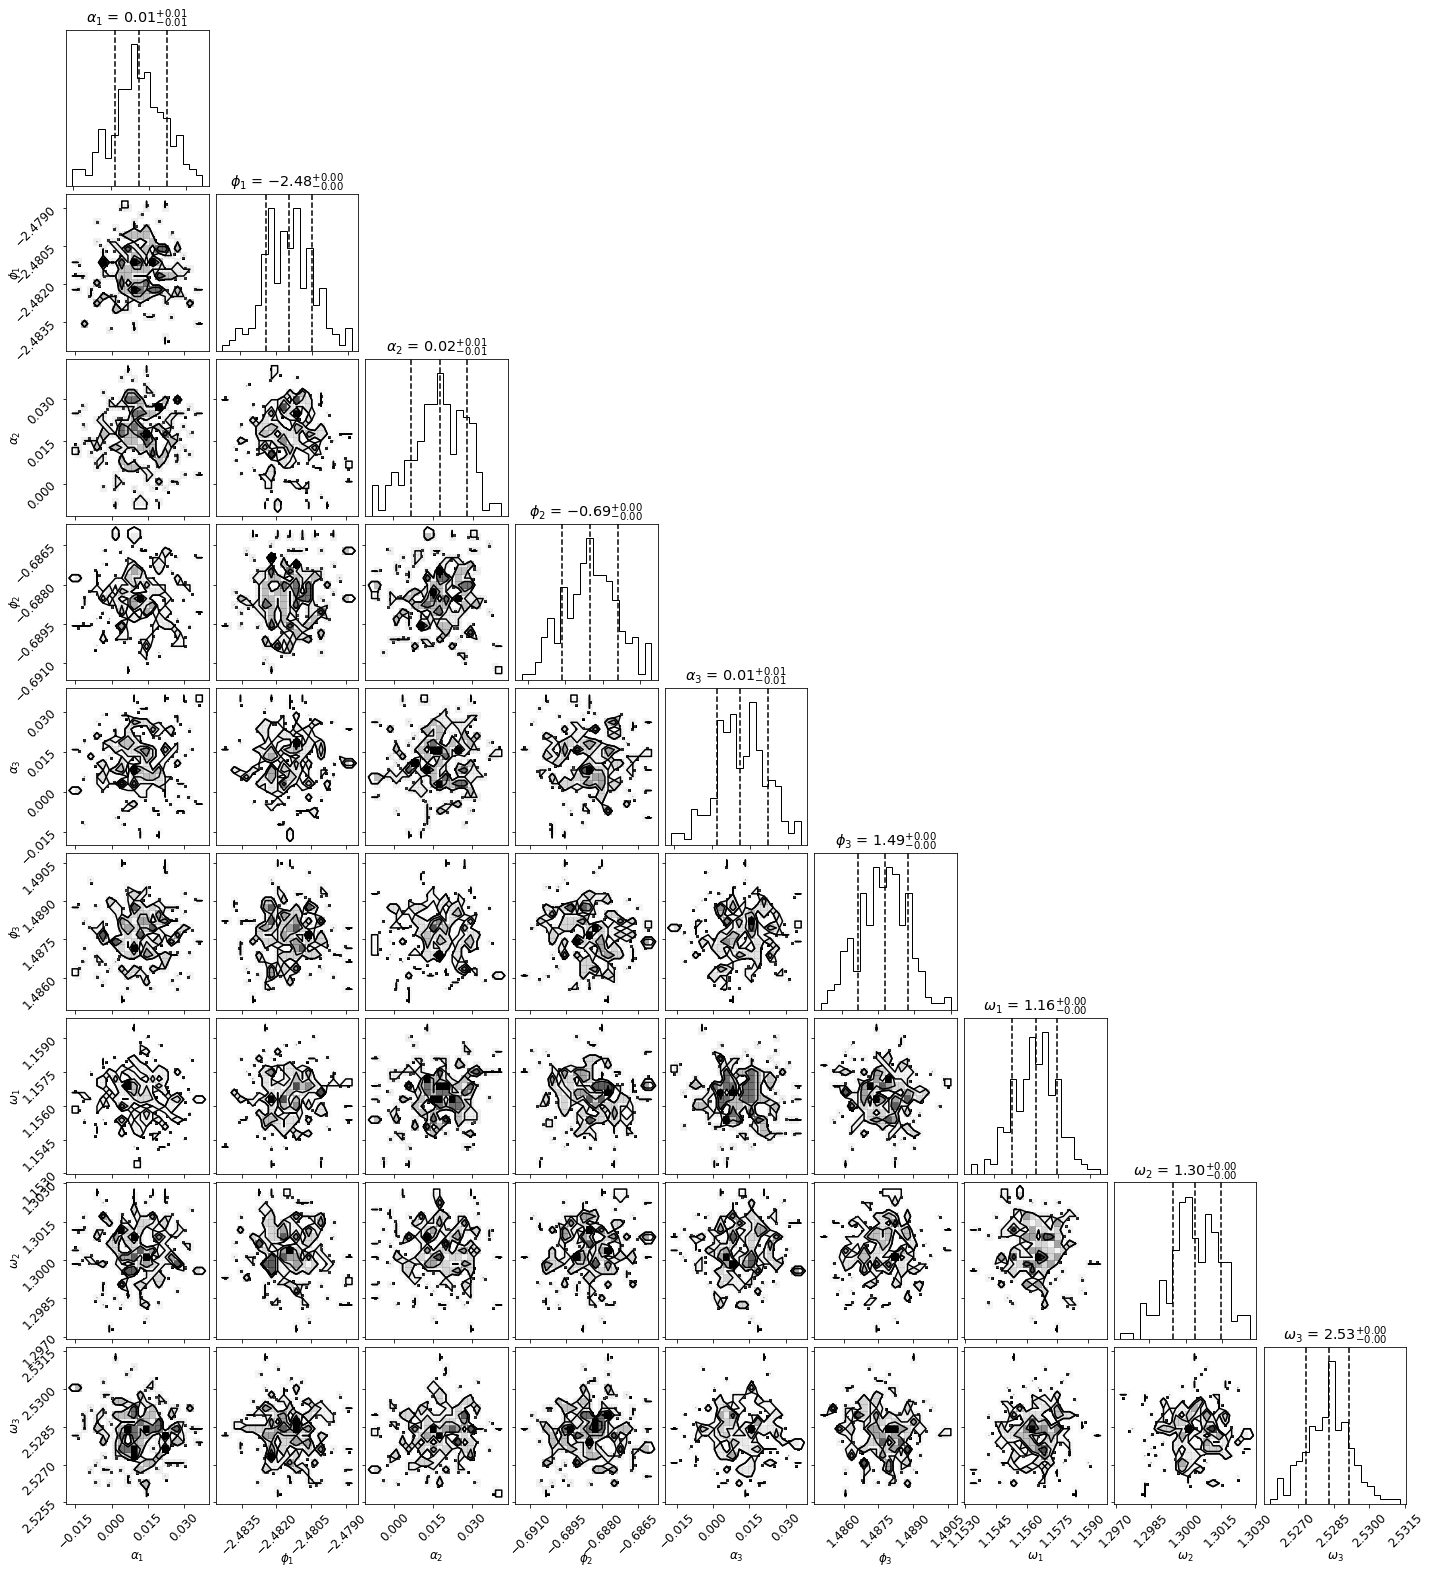

In [132]:
## CORNER PLOT OF PRIOR PROBABILITY DISTRIBUTION
import corner
matplotlib.rcParams.update({'font.size': 12})
labels = [r'$\alpha_1$', r'$\phi_1$', r'$\alpha_2$', r'$\phi_2$', r'$\alpha_3$', r'$\phi_3$', r'$\omega_1$', r'$\omega_2$', r'$\omega_3$']
p = plt.figure(figsize=(20,22))
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84], fig=p)

## Saving
save = True
if save:
    handle_code = 'MCMC'
    plotOut = plotPath + '/posteriorDistribution_%s_sector3637_%i_%i-hr_fit'%(handle_code, tlow, thigh)
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

In [46]:
samples.shape

(2000000, 9)

In [48]:
sampler.flatchain

array([[ 5.58209019e-03, -2.48264658e+00,  3.49219409e-02, ...,
         1.15657579e+00,  1.30101372e+00,  2.52758825e+00],
       [ 2.64790402e-02, -2.48210017e+00,  1.62197843e-02, ...,
         1.15587570e+00,  1.30128658e+00,  2.52852665e+00],
       [ 4.75695952e-03, -2.48101112e+00,  2.25394160e-02, ...,
         1.15846799e+00,  1.30049473e+00,  2.52835050e+00],
       ...,
       [ 1.29940116e-02, -2.48070959e+00,  2.50707900e-03, ...,
         1.15529930e+00,  1.29935658e+00,  2.52926211e+00],
       [ 1.69558895e-02, -2.48233023e+00,  9.97911654e-03, ...,
         1.15646791e+00,  1.29901135e+00,  2.52830747e+00],
       [ 2.10519424e-02, -2.48115293e+00,  1.24294899e-02, ...,
         1.15664939e+00,  1.29925329e+00,  2.52814758e+00]])